In [1]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
from torchvision import  models
from torchvision import transforms
from torchvision.utils import save_image

### Loading the Images

In [3]:
res = requests.get('https://raw.githubusercontent.com/soumyajit4419/Neural_Style_Transfer/master/Assets/person1.jpeg?token=AK7VCICI7JMG7N7O4SZVF7S7BMAYA')
content = Image.open(BytesIO(res.content)).convert('RGB')

res = requests.get('https://raw.githubusercontent.com/soumyajit4419/Neural_Style_Transfer/master/Assets/paiting_night.jpeg?token=AK7VCIGI7JOAR2BUHYZNRKC7BMAZ4')
style = Image.open(BytesIO(res.content)).convert('RGB')

### Converting them to tensor

In [4]:
# Resizing the images and converting into tensor
height = 400
width = 500
transform = transforms.Compose([
                                transforms.Resize((height,width)),
                                transforms.ToTensor()
                             ])    

content_image = transform(content)
style_image = transform(style)      

In [5]:
print(content_image.shape)
print(style_image.shape)

torch.Size([3, 400, 500])
torch.Size([3, 400, 500])


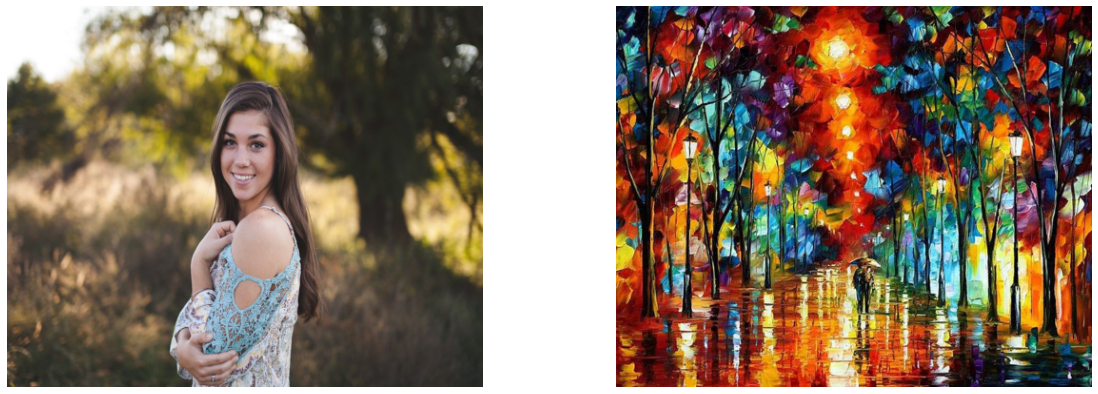

In [6]:
# Viewing the images
fig,(ax1,ax2) = plt.subplots(figsize=(20,7),nrows=1,ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.imshow(content_image.permute(1,2,0))
ax2.imshow(style_image.permute(1,2,0))
plt.show()

### Loading the Model
VGG19 model has two parts Features and Classifier. As we are not training an CNN we dont need the classifier, We only need to get the features of the image and also freeze the layers by setting the "requires_grad" to false as we dont want to update the weights and baises of the pretrained model.

In [7]:
# Loading VGG19 model
model = models.vgg19(pretrained=True).features

for param in model.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [8]:
# Selecting GPU device if available
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()
device

device(type='cuda')

In [9]:
# Moving the model to GPU
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [10]:
# add a batchsize to image
content_image = content_image.unsqueeze(0)
style_image = style_image.unsqueeze(0)

# moving the images to the device
content_image = content_image.to(device)
style_image = style_image.to(device)

In [11]:
def get_features(model,image):

  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2', #Content of target 
      '28' : 'conv5_1'
       }
  
  features = {}
  x = image
  for name,layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x
  
  return features

In [12]:
def  get_gram_matrix(tensor):

  _,d,h,w = tensor.size()

  tensor = tensor.view(d, h*w)
  gram_matrix = torch.mm(tensor,tensor.t())
  return gram_matrix

In [13]:
content_features = get_features(model, content_image)
style_features = get_features(model, style_image)

style_grams = {layer : get_gram_matrix(style_features[layer]) for layer in style_features}

In [14]:
# Creating a target image same as content image 
target = content_image.clone().requires_grad_(True).to(device)

In [15]:
# Initialzing weights
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e5  # beta

In [16]:
def im_convert(target):
  image = target.to("cpu").clone().detach()
  image = image.squeeze()
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  19800.02734375


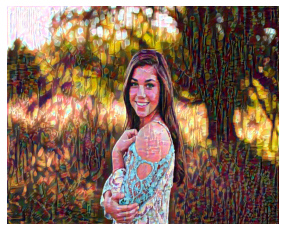

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  8225.212890625


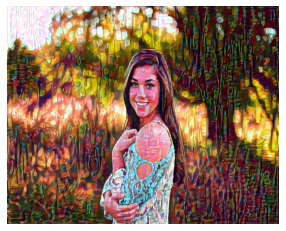

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  4959.73828125


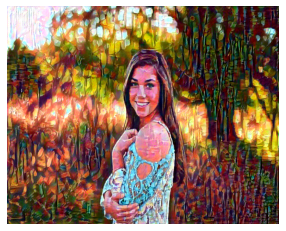

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  3248.75048828125


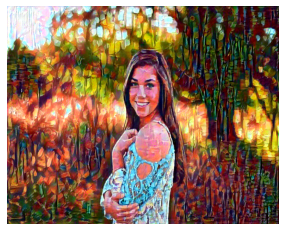

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  2277.517822265625


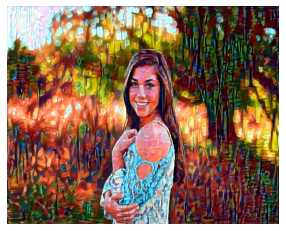

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  1727.31201171875


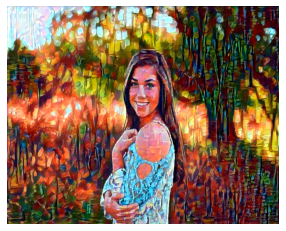

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  1383.387939453125


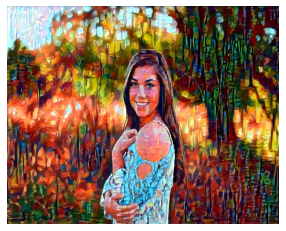

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss:  1145.380126953125


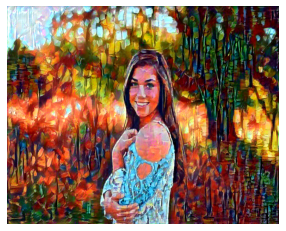

In [17]:
show_every = 500
optimizer = torch.optim.Adam([target],lr=0.002)
steps = 4000

for i in range(1,steps+1):

  target_features = get_features(model,target)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = get_gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    style_loss += layer_style_loss / (d * h * w)

  total_loss = content_weight * content_loss + style_weight * style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if  i % show_every == 0:
    print('Total loss: ', total_loss.item())
    tag_img = im_convert(target)
    plt.imshow(tag_img.permute(1,2,0))
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


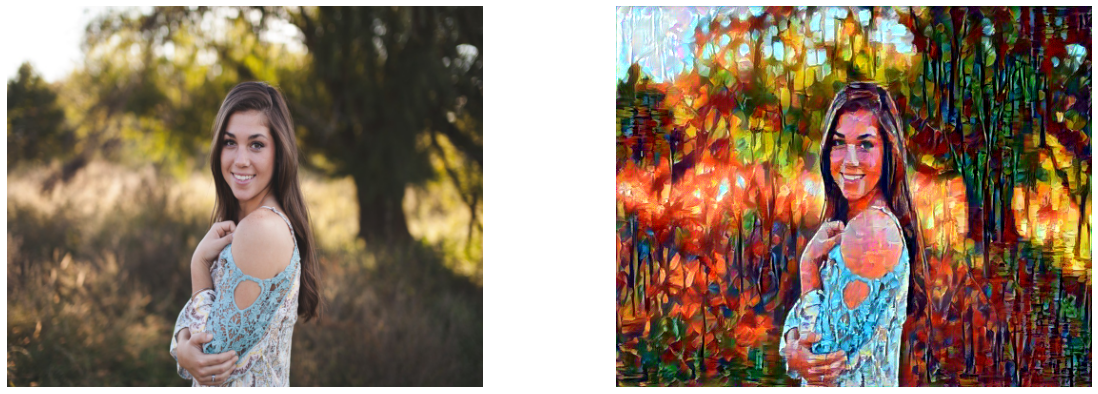

In [18]:
# Ploting both the input and target images
ci = im_convert(content_image)
ti = im_convert(target)
fig , (ax1,ax2) = plt.subplots(figsize=(20,7),nrows=1,ncols=2)
ax1.imshow(ci.permute(1,2,0))
ax1.axis("off")
ax2.imshow(ti.permute(1,2,0))
ax2.axis("off")
plt.show()

In [19]:
# Saving the output images
save_image(ti, 'girl_painting.jpg')